In [13]:
from __future__ import annotations
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader

from torch import nn, optim
import itertools

import os
from matplotlib import rc, colors
rc("font", **{"family": "serif", "serif": ["Times"]})
rc("text", usetex=True)

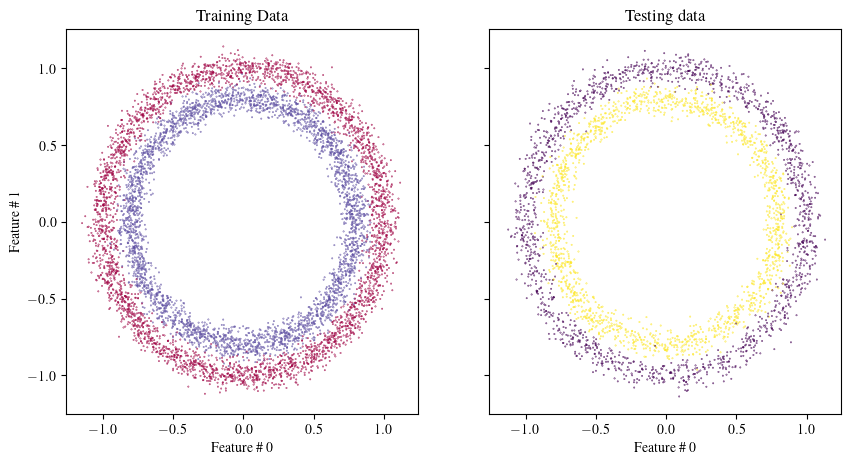

In [4]:
# Create a dataset with 10,000 samples.
X, y = make_circles(n_samples=10000, noise=0.05, random_state=26)

# make_circles = Make a large circle containing a smaller circle in 2d. 
# A simple toy dataset to visualize clustering and classification algorithms.
# where, n_samples = total number of points generated, noise = Standard deviation of Gaussian noise added to the data, 
# random_state = Determines random number generation for dataset shuffling and noise. Pass an int for reproducible output across multiple function calls.
# Returns, X = The generated samples, y = The integer labels (0 or 1) for class membership of each sample.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=26
)

# train_test_split = Split arrays or matrices into random train and test subsets where, test_size = If float, should be between 0.0 and 1.0 and 
# represent the proportion of the dataset to include in the test split. If int, represents the absolute number of test samples. If None, the value 
# is automatically set to the complement of the train size, random_state = Controls the shuffling applied to the data before applying the split. 
# Pass an int for reproducible output across multiple function calls. Returns, List containing train-test split of inputs.

# Visualize the data.
fig, (train_ax, test_ax) = plt.subplots(
    ncols=2, sharex=True, sharey=True, figsize=(10, 5)
)
train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Spectral, s=0.1)
train_ax.set_title(r"Training Data")
train_ax.set_xlabel(r"Feature \# 0")
train_ax.set_ylabel(r"Feature \# 1")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=0.1)
test_ax.set_xlabel(r"Feature \# 0")
test_ax.set_title(r"Testing data")
plt.show()


In [5]:
# Convert data to torch tensors
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len
    
# Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable 
# easy access to the samples.
# The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to 
# pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing 
# to speed up data retrieval. DataLoader is an iterable that abstracts this complexity for us in an easy API.

# Dataset = 
"""An abstract class representing a :class:`Dataset`.

    All datasets that represent a map from keys to data samples should subclass
    it. All subclasses should overwrite :meth:`__getitem__`, supporting fetching a
    data sample for a given key. Subclasses could also optionally overwrite
    :meth:`__len__`, which is expected to return the size of the dataset by many
    :class:`~torch.utils.data.Sampler` implementations and the default options
    of :class:`~torch.utils.data.DataLoader`. Subclasses could also
    optionally implement :meth:`__getitems__`, for speedup batched samples
    loading. This method accepts list of indices of samples of batch and returns
    list of samples.

    .. note::
      :class:`~torch.utils.data.DataLoader` by default constructs an index
      sampler that yields integral indices.  To make it work with a map-style
      dataset with non-integral indices/keys, a custom sampler must be provided.
"""

# DataLoader = 
"""
Data loader combines a dataset and a sampler, and provides an iterable over the given dataset.
"""

batch_size = 64

# Instantiate training and test data
train_data = Data(X_train, y_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = Data(X_test, y_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

# Check it's working
for batch, (X, y) in enumerate(train_dataloader):
    print(f"Batch: {batch+1}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    break

Batch: 1
X shape: torch.Size([64, 2])
y shape: torch.Size([64])


In [6]:
# A two-layer neural network that uses the ReLU activation function (torch.nn.functional.relu)

input_dim = 2
hidden_dim = 10
output_dim = 1

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        nn.init.kaiming_uniform_(self.layer_1.weight, nonlinearity="relu") # Weight initialisation 
        self.layer_2 = nn.Linear(hidden_dim, output_dim)
       
    def forward(self, x):
        x = torch.nn.functional.relu(self.layer_1(x)) # Activation function layer 1
        x = torch.nn.functional.sigmoid(self.layer_2(x)) # Activation function layer 2

        return x

## nn.Module = base class for all neural network modules built in PyTorch 
## super = to overload
## nn.Linear = Applies an affine linear transformation to the incoming data: :math:`y = xA^T + b`.
## nn.init.kaiming_uniform_ = Fill the input `Tensor` with values using a Kaiming uniform distribution.
## torch.nn.functional.relu = Applies the rectified linear unit function element-wise.
## torch.nn.functional.sigmoid = Applies the element-wise function :math:`\text{Sigmoid}(x) = \frac{1}{1 + \exp(-x)}` element-wise.

model = NeuralNetwork(input_dim, hidden_dim, output_dim)
print(model)

NeuralNetwork(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=1, bias=True)
)


In [7]:
# To train the model we must define a loss function to use to calculate the gradients and an optimizer to update the parameters. 

learning_rate = 0.1

loss_fn = nn.BCELoss() # binary crossentropy as loss function 

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # stochastic gradient descent as optimizer 


In [8]:
num_epochs = 100
loss_values = []
test_loss_values = []

In [ ]:
for epoch in range(num_epochs):
    for X, y in train_dataloader:
        # zero the parameter gradients
        optimizer.zero_grad()
       
        # forward + backward + optimize
        pred = model(X) # forward 
        loss = loss_fn(pred, y.unsqueeze(-1))
        loss_values.append(loss.item()) # track loss
        loss.backward() # backward
        optimizer.step() # optimize

print("Training Complete")

In [9]:
for epoch in range(num_epochs):
    model.train()  # Ensure the model is in training mode during training

    # Training phase (this part is the same as your original code)
    for X, y in train_dataloader:
        optimizer.zero_grad()  # Zero the parameter gradients
        pred = model(X)  # Forward pass
        loss = loss_fn(pred, y.unsqueeze(-1))  # Calculate the loss
        loss_values.append(loss.item())  # Track loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize the model parameters

    # After each epoch, evaluate on the test dataset
    model.eval()  # Set model to evaluation mode for test evaluation

    with torch.no_grad():  # Disable gradient computation during evaluation
        for X_test, y_test in test_dataloader:
            # Forward pass on the test set
            pred_test = model(X_test)
            
            # Calculate test loss
            loss_test = loss_fn(pred_test, y_test.unsqueeze(-1))
            
            # Track the test loss
            test_loss_values.append(loss_test.item())

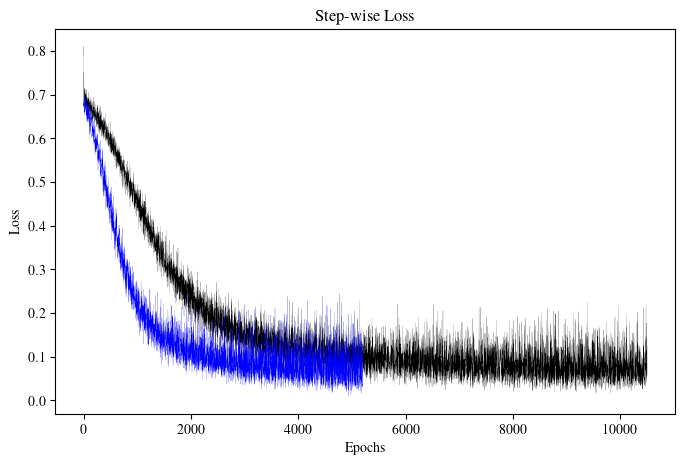

In [15]:
# visualise loss

step = range(len(loss_values))
step_test = range(len(test_loss_values))

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(loss_values), c='black', lw=0.1)
plt.plot(step_test, np.array(test_loss_values), c='blue', lw=0.1)
plt.title("Step-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig(os.path.join(os.getcwd(), "loss.png"), dpi=500)
plt.show()

In [16]:
# Initialize required variables
y_pred = []
y_test = []
correct = 0
total = 0

In [17]:
# We're not training so we don't need to calculate the gradients for our outputs

with torch.no_grad():
        for X, y in test_dataloader:
            outputs = model(X)  # Get model outputs
            predicted = np.where(outputs.numpy() < 0.5, 0, 1)  # Convert to NumPy and apply threshold
            predicted = list(itertools.chain(*predicted))  # Flatten predictions
            y_pred.append(predicted)  # Append predictions
            y_test.append(y.numpy())  # Append true labels as NumPy

            total += y.size(0)  # Increment total count
            correct += (predicted == y.numpy()).sum().item()  # Count correct predictions


"""
The code above loops through the test batches, which are stored in the test_dataloader variable, without calculating the gradients. 
We then predict the instances in the batch and store the results in a variable called outputs. Next, we determine set all the values 
less than 0.5 to 0 and those equal to or greater than 0.5 to 1. These values are then appended to a list for our predictions.

After that, we add the actual predictions of the instances in the batch to a variable named total. Then we calculate the number of 
correct predictions by identifying the number of predictions equal to the actual classes and totaling them. The total number of 
correct predictions for each batch is incremented and stored in our correct variable.

To calculate the accuracy of the overall model, we multiply the number of correct predictions by 100 (to get a percentage) and 
then divide it by the number of instances in our test set. Our model had 97% accuracy. 
"""

print(f'Accuracy of the network on the 3300 test instances: {100 * correct // total}%')

Accuracy of the network on the 3300 test instances: 97%


In [18]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import seaborn as sns

"""
We dig in further using the confusion matrix and scikit-learn’s classification_report to get a better understanding of how our model 
performed.
"""

'\nWe dig in further using the confusion matrix and scikit-learn’s classification_report to get a better understanding of how our model \nperformed.\n'

In [19]:
y_pred = list(itertools.chain(*y_pred))
y_test = list(itertools.chain(*y_test))

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98      1635
         1.0       0.98      0.98      0.98      1665

    accuracy                           0.98      3300
   macro avg       0.98      0.98      0.98      3300
weighted avg       0.98      0.98      0.98      3300



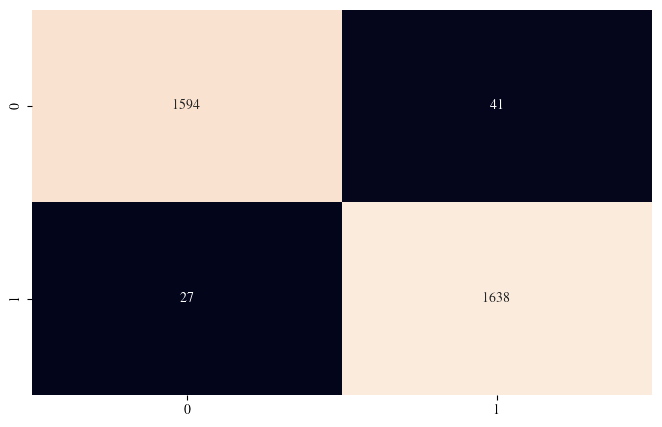

In [20]:
cf_matrix = confusion_matrix(y_test, y_pred)

plt.subplots(figsize=(8, 5))

sns.heatmap(cf_matrix, annot=True, cbar=False, fmt="g")

plt.show()